# Effect of socioeconomic and health-related factors on adherence to chronic disease medication in India: analysis of cross sectional data from WHO - SAGE2 

Complete Code for analysis

# Import Packages

In [1]:
## Language = "R"
#The following install commands only need to be run once and then commented out
# install.packages("ggthemes")
# install.packages("RColorBrewer")
# install.packages("scatterplot3d")
# install.packages("effsize")
# install.packages("lsr")
# install.packages("AMR")
# install.packages("oddsratio")
# install.packages("dplyr")  
# install.packages("epitools")
# install.packages("questionr")
# install.packages("forcats")
# install.packages("plyr")
# install.packages("stargazer") 
# install.packages("caret") 
# install.packages("leaps") 
# install.packages("MASS") 
# install.packages("car") 
# install.packages("survey")
# install.packages("magrittr")
# install.packages("jtools")
# install.packages("ggpubr")

In [2]:
# Activating packages
suppressWarnings(suppressMessages({
library(tidyverse)  # Modern data science workflow
library(ggplot2) # Modern visualization tools
library(ggpubr) # for combining figures
library(ggrepel) ## For displaying label on ggplot2 object
library(haven) # for reading .dta files
library(dplyr)
library(stargazer) #for regression results
library(epitools) #for odds_ratio
library(car) #for VIF
library(survey) #for survey weighting
}))


In [3]:
# Adjustments
#knitr::opts_chunk$set(fig.align = "center")
knitr::opts_chunk$set(echo = TRUE)
options(warn = -1)
options(scipen = 10000)
options(repr.plot.width = 12, repr.plot.height = 4)

In [4]:
citation()
# citation("tidyverse")  # Modern data science workflow
# citation("ggplot2") # Modern visualization tools
# citation("ggpubr") # for combining figures
# citation("ggrepel") ## For displaying label on ggplot2 object
# citation("haven") # for reading .dta files
# citation("dplyr")
# citation("stargazer") #for regression results
# citation("epitools") #for odds_ratio
# citation("car") #for VIF
# citation("survey") #for survey weighting
# toBibtex(citation("survey"))


To cite R in publications use:

  R Core Team (2022). R: A language and environment for statistical
  computing. R Foundation for Statistical Computing, Vienna, Austria.
  URL https://www.R-project.org/.

A BibTeX entry for LaTeX users is

  @Manual{,
    title = {R: A Language and Environment for Statistical Computing},
    author = {{R Core Team}},
    organization = {R Foundation for Statistical Computing},
    address = {Vienna, Austria},
    year = {2022},
    url = {https://www.R-project.org/},
  }

We have invested a lot of time and effort in creating R, please cite it
when using it for data analysis. See also 'citation("pkgname")' for
citing R packages.


Package and base r versions

In [5]:
R.Version()$version.string
packageVersion("tidyverse")  # Modern data science workflow
packageVersion("ggplot2") # Modern visualization tools
packageVersion("ggpubr") # for combining figures
packageVersion("ggrepel") ## For displaying label on ggplot2 object
packageVersion("haven") # for reading .dta files
packageVersion("dplyr")
packageVersion("stargazer") #for regression results
packageVersion("epitools") #for odds_ratio
packageVersion("car") #for VIF
packageVersion("survey") #for survey weighting

[1] "R version 4.2.2 (2022-10-31 ucrt)"

[1] '1.3.2'

[1] '3.3.6'

[1] '0.4.0'

[1] '0.9.1'

[1] '2.5.1'

[1] '1.0.10'

[1] '5.2.3'

[1] '0.5.10.1'

[1] '3.1.1'

[1] '4.1.1'

# Initialisation
Importing data if necessary

In [6]:
# clear variables and read data from dta
rm(list=ls())

# we are using haven from the Tidyverse library to import a stata file
# this has both advantages (data fidelty) but also some complexity
# stata (and SPSS / SAS) have labelled values
# so we have to deal with that
Setup = "Y"

if (Setup == "Y"){
    dta_raw <- read_dta("SAGE_India_W2_IND_Data.dta")
}



## Create subdirectories
These are used to organise outputted csv"s and figures

In [7]:
dir.create(file.path(getwd(), "Supplementary2"), recursive = TRUE)
dir.create(file.path(getwd(), "Supplementary3"), recursive = TRUE)
dir.create(file.path(getwd(), "Figures"), recursive = TRUE)
dir.create(file.path(getwd(), "Misc"), recursive = TRUE)

# Data Cleanup

Cleaning up values

## Deal with zero values vs "no value"
5 columns have 0 as the "No" value as opposed to 2: 4001, 4014, 4033, 4040 and 4060.
So we change the 0 value to 2 - makes subsequent analysis easier.

In [8]:
if (Setup == "Y"){
    dta_raw$q4001 <- replace(dta_raw$q4001, dta_raw$q4001==0, 2)
    dta_raw$q4014 <- replace(dta_raw$q4014, dta_raw$q4014==0, 2)
    dta_raw$q4033 <- replace(dta_raw$q4033, dta_raw$q4033==0, 2)
    dta_raw$q4040 <- replace(dta_raw$q4040, dta_raw$q4040==0, 2)
    dta_raw$q4060 <- replace(dta_raw$q4060, dta_raw$q4060==0, 2)
}

## Correct questions missing labels
q1016 and q4033 had no labels attatched: copying from columns with the same labels (as per questionnaire)

In [9]:
if (Setup == "Y"){  
    attr(dta_raw$q4033, "class") <- attr(dta_raw$q4022, "class") 
    attr(dta_raw$q4033, "format.stata") <- attr(dta_raw$q4022, "format.stata") 
    attr(dta_raw$q4033, "labels") <- attr(dta_raw$q4022, "labels") 
}

if (Setup == "Y"){
    attributes(dta_raw$q1016_) <- attributes(dta_raw$q1028)
    attr(dta_raw$q1016_, "label") <- "Level of Education"
}

## Correct question 5053
q5053 has 2 associated columns, the correct one being q5053_new, as the labels on 5053 are incorrect

In [10]:
if (Setup == "Y"){
    dta_raw$q5053<-dta_raw$q5053_new
    dta_raw <- subset(dta_raw , select = -c(q5053_new))
}

## Correct question 7010
q7010 has 68 labelled as "Don"t know" value as opposed to 8: as such all values 8 are replaced by 68

In [11]:
if (Setup == "Y"){
    dta_raw$q7010 <- replace(dta_raw$q7010, dta_raw$q7010==8, 68)
}

## Rename Columns
Some questions do not have meaningful names associated with them

In [12]:
if (Setup == "Y"){
    attr(dta_raw$q8062, "label") <- "Community Support"
    attr(dta_raw$q0105a, "label")<- "Region"
}

## Rename Factors
Some factors are misspelt / formatted

In [13]:
if (Setup == "Y"){
    levels(dta_raw$q0105a)<-list("Assam"=c("ASSAM"),"Karnataka"=c("KARNATAKA"), "Maharashtra"=c("MAHARASHTRA"), "Rajasthan"=c("RAJASTHAN"), "Uttar Pradesh"=c("UTTAR PRADESH"), "West Bengal"=c("WEST BENGAL"))
}

## Save edited dta

In [14]:
if (Setup == "Y"){
    write_dta(
    dta_raw,
    "dta_edit.dta"
    )
} else {
    dta_raw <- read_dta("dta_edit.dta")
}

## Data refactoring

As the data is in a haven structure we can "zap" the labels to obtain the values per se

In [15]:
data <- haven::as_factor(dta_raw, levels = "default")
write.csv(data,"SAGE_India_W2_IND_Data_Cleaned.csv")

# Preparing data for analysis
The creation of morbidity and multiadherence metrics, and regrouping of other factors

## Creating Morbidity and Adherence Metrics

Creation of an alternative string count function to ignore NA values

In [16]:
string_count <- function(string, search){
    count = str_count(string, search)
    count <- ifelse(is.na(count), 0, count)
    return(count)
}

### Calculation of Morbidity and Multimorbidity statistics

This counts the number of chronic diseases of each respondent (`count_diseases`). If this is 1 or greater, the respondent is classed as having any morbidity. If this is 2 or greater, they are counted as having multimorbidity, and if it is 3 or greater, classed as having complex multimorbidity.

In [17]:
#disease
data <- data %>%
 mutate(count_diseases = string_count(q4010, "Yes") + string_count(q4014, "Yes")+ string_count(q4022, "Yes")+string_count(q4033, "Yes")+string_count(q4025, "Yes")+string_count(q4040, "Yes")+string_count(q4060, "Yes")) %>% 
 mutate(anymorbidity = case_when (count_diseases >= 1 ~ "Yes", count_diseases < 1 ~ "No")) %>%
 mutate(multimorbidity = case_when (count_diseases >= 2 ~ "Yes", count_diseases < 2 ~ "No")) %>%
 mutate(complex_multimorbidity = case_when (count_diseases > 2 ~ "Yes", count_diseases <= 2 ~ "No"))
 

attr(data$count_diseases, "label") <- "Number of Chronic Conditions"
attr(data$anymorbidity, "label") <- "Any Morbidity"
attr(data$complex_multimorbidity, "label") <- "Complex Multimorbidity"
attr(data$multimorbidity, "label") <- "Multimorbidity"

### Calculation of Partial and Complete Adherence statistics
This counts the number of chronic diseases to which the respondent said they had taken medication for over the past two weeks (`count_adh`). If this is greater than 0, the respondent is classed as having any partial adherence. If this is equal to the number of chronic conditions with which they are diagnosed (`count_diseases`), they are counted as having complete adherence.

In [18]:
data <- data %>%
 mutate(count_adh = string_count(q4011a, "Yes") + string_count(q4015a, "Yes")+ string_count(q4023a, "Yes")+string_count(q4034a, "Yes")+string_count(q4026a, "Yes")+string_count(q4041a, "Yes")+string_count(q4061a, "Yes")) %>%
 mutate(count_treat_last12 = string_count(q4011b, "Yes") + string_count(q4015b, "Yes")+ string_count(q4023b, "Yes")+string_count(q4034b, "Yes")+string_count(q4026b, "Yes")+string_count(q4041b, "Yes")+string_count(q4061b, "Yes")) %>%
 mutate(adherence = case_when (count_diseases == count_adh ~ "Yes", count_diseases != count_adh  ~ "No")) %>%
 mutate(twelve_adherence = case_when (count_diseases == count_treat_last12 ~ "Yes", count_diseases != count_treat_last12  ~ "No")) %>%
 mutate(partial_adherence = case_when (count_adh > 0 ~ "Yes", count_adh <= 0 ~ "No"))%>%
 mutate(discordant_adherence = case_when (count_treat_last12 > count_adh ~ "Yes", count_treat_last12 <= count_adh ~ "No"))

attr(data$adherence, "label") <- "Complete Adherence"
attr(data$partial_adherence, "label") <- "Partial Adherence"
attr(data$discordant_adherence, "label") <- "Discordant Adherence"

In [19]:
attr(data$adherence, "levels") <- attr(data$q4011a, "levels")
data$adherence  <- factor(data$adherence )
attr(data$adherence, "label") <- "Complete Adherence"
attr(data$twelve_adherence, "levels") <- attr(data$q4011a, "levels")
data$twelve_adherence  <- factor(data$twelve_adherence )
attr(data$twelve_adherence, "label") <- "12M Adherence"

## Create Age Categories

Thse age categories are the same as those used in the [original SAGE2 paper](https://iipsindia.ac.in/sites/default/files/other_files/WHO-SAGE_Wave-2_India_Report.pdf)

* < 50 (classed as younger adults)

* \>=50 (classed as older adults)

In [20]:
data <- data %>% mutate(age_category = case_when(q1011 < 50 ~ "<50",
                                             q1011 >= 50   ~ ">=50"
                                             ))


data$age_category  <- factor(data$age_category)
attr(data$age_category, "label") <- "Age Group"

## Regroup Variables

In [21]:
levels(data$q1016_)<- list("Less than primary school/don't know"=c("No formal education","Less than primary school","Don't know"), "Secondary school and below"=c("Primary school completed","Secondary school completed"), "Past secondary school"=c("High school(or equivalent) completed","College/pre-university/uiversity completed","Post-graduate completed"))
levels(data$q1019_)<-list("Hinduism"=c("Hinduism"),"Islam"=c("Islam"),"Other / None"=c("Buddhism","Chinese traditional religion","Christianoty","Jainism","Judaism","Primal Indigenous","Sikhism","Others", "No/None", "Refused"))
levels(data$q5004)<-list("Private"=c("Private doctor\"s office","Private clinic/Health care facility","Private hospitals"), "Public"=c("Public clinic/Health care facility","Public hospital"),"Community"=c("Charity/Church run clinic","Charity/Church run hospital","Traditional healer", "Pharmacy/Dispensary"),"Other"=c("Others"))
levels(data$q1012)<-list("Currently Married"=c("Currently Married"), "Not Currently Married"=c("Never Married","Cohabiting","Separated/Divorced","Widowed"))
levels(data$q1018_)<- list("Schedule Tribe"=c("Schedule Tribe"), "Schedule Caste"=c("Schedule Caste"), "Others"=c("Other Backward Caste","None of the Above","Others", "Dont Know"))

### Futher Regrouping

For the following questions, the extreme categories tend to have very few respondants. As such, these categories are regrouped into Bad, encompassing moderate severe and extreme, and None/Mild for none/mild 

In [22]:
levels(data$q2002) <- list("Moderate or worse"=c("Moderate", "Severe", "Extreme/Cannot do"),"None/Mild"=c("None","Mild")) 
levels(data$q2018) <- list("Moderate or worse"=c("Moderate", "Severe", "Extreme/Cannot do"),"None/Mild"=c("None","Mild")) 
levels(data$q2019) <- list("Moderate or worse"=c("Moderate", "Severe", "Extreme/Cannot do"),"None/Mild"=c("None","Mild")) 
levels(data$q2010) <- list("Moderate or worse"=c("Moderate", "Severe", "Extreme/Cannot do"),"None/Mild"=c("None","Mild")) 

For the following questions, the extreme categories tend to have very few respondents. As such, these categories are regrouped into Poor, encompassing moderate, bad and very bad, and Good for Very good and Good

In [23]:
levels(data$q2000)<- list("Poor"=c("Bad", "Very Bad", "Moderate"),"Good"=c("Good","Very good"))

## Set reference levels

In [24]:
label.4040 <- attr(data$q4040, "label") 
label.4062 <- attr(data$q4062, "label") 
label.3001 <- attr(data$q3001, "label") 
label.2018 <- attr(data$q2018, "label") 
label.2019 <- attr(data$q2019, "label") 
label.quintile <- attr(data$quintile, "label") 

In [25]:
data <- within(data, q4040 <- relevel(q4040, ref = "No"))
data <- within(data, q4062 <- relevel(q4062, ref = "No"))
data <- within(data, q3001 <- relevel(q3001, ref = "No"))
data <- within(data, q2018 <- relevel(q2018, ref = "None/Mild"))
data <- within(data, q2019 <- relevel(q2019, ref = "None/Mild"))
data$quintile <- as.factor(data$quintile)

In [26]:
attr(data$q4040, "label") <- label.4040
attr(data$q4062, "label") <-  label.4062
attr(data$q3001, "label")  <- label.3001
attr(data$q2018, "label")  <- label.2018
attr(data$q2019, "label")  <- label.2019
attr(data$quintile, "label")  <- label.quintile

# Restrict Data

Include only those people who answered the survey

In [27]:
data <- data[!is.na(data$pweight),]

### proportions for each adherence metric

In [28]:
print("complete adherence")
print(length(which((data$adherence == "Yes") & (data$anymorbidity == "Yes"))))
print(length(which((data$adherence == "No") & (data$anymorbidity == "Yes"))))

print("partial adherence")
print(length(which((data$partial_adherence == "Yes") & (data$anymorbidity == "Yes"))))
print(length(which((data$partial_adherence == "No") & (data$anymorbidity == "Yes"))))

print('discordant adherence')
print(length(which((data$discordant_adherence == "Yes") & (data$anymorbidity == "Yes"))))
print(length(which((data$discordant_adherence == "No") & (data$anymorbidity == "Yes"))))


[1] "complete adherence"
[1] 1418
[1] 1422
[1] "partial adherence"
[1] 1728
[1] 1112
[1] "discordant adherence"
[1] 405
[1] 2435


In [29]:

print('discordant adherence')
print(length(which((data$count_adh == data$count_treat_last12) & (data$anymorbidity == "Yes"))))
print(length(which((data$count_adh > data$count_treat_last12) & (data$anymorbidity == "Yes"))))
print(length(which((data$count_adh < data$count_treat_last12) & (data$anymorbidity == "Yes"))))

[1] "discordant adherence"
[1] 2151
[1] 284
[1] 405


In [30]:
print('12M vs 2W adherence')
print(length(which((data$adherence == "Yes") & (data$twelve_adherence == "Yes") & (data$anymorbidity == "Yes"))))
print(length(which((data$adherence == "Yes") & (data$twelve_adherence == "No") & (data$anymorbidity == "Yes"))))
print(length(which((data$adherence == "No") & (data$twelve_adherence == "Yes") & (data$anymorbidity == "Yes"))))
print(length(which((data$adherence == "No") & (data$twelve_adherence == "No") & (data$anymorbidity == "Yes"))))

[1] "12M vs 2W adherence"
[1] 1184
[1] 234
[1] 343
[1] 1079


In [31]:
write.csv(data,"SAGE_India_W2_IND_Data_Cleaned_Modified.csv")

# Create Survey Design
Create survey design object encoding weights and PSU"s

In [32]:
surveyDesign <- svydesign(ids=~q0101b, weights=~pweight, data=data)
SurveyDesign <- surveyDesign

## Subset of survey design
Create a survey design object that is a subset of those with any chronic condition. When both exists, survey design objects will be `PascalCase` whilst their corresponding dataframes will be `camelCase`

In [33]:
Morbidity         <- subset(surveyDesign, anymorbidity == "Yes") #survey design object
morbidity         <- as.data.frame(subset(data, data$anymorbidity=="Yes")) # dataframe

Multimorbid       <- subset(Morbidity, multimorbidity== "Yes")
multimorbid       <- as.data.frame(subset(morbidity, morbidity$multimorbidity=="Yes"))

Unimorbid         <- subset(Morbidity, multimorbidity== "No")
unimorbid         <- as.data.frame(subset(morbidity, morbidity$multimorbidity=="No"))

Check             <- subset(surveyDesign, q1011 >= 50) # this exists to be able to compare specific results with those in the SAGE2 India paper, to confirm the analysis done in this code

Stroke            <- subset(surveyDesign, q4010== "Yes")
Angina            <- subset(surveyDesign, q4014== "Yes")
Diabetes          <- subset(surveyDesign, q4022== "Yes")
LungDisease       <- subset(surveyDesign, q4025== "Yes")
Asthma            <- subset(surveyDesign, q4033== "Yes")
Depression        <- subset(surveyDesign, q4040== "Yes")
Hypertension      <- subset(surveyDesign, q4060== "Yes")

stroke            <- as.data.frame(subset(data, data$q4010=="Yes"))
angina            <- as.data.frame(subset(data, data$q4014=="Yes"))
diabetes          <- as.data.frame(subset(data, data$q4022=="Yes"))
lungDisease       <- as.data.frame(subset(data, data$q4025=="Yes"))
asthma            <- as.data.frame(subset(data, data$q4033=="Yes"))
depression        <- as.data.frame(subset(data, data$q4040=="Yes"))
hypertension      <- as.data.frame(subset(data, data$q4060=="Yes"))

Adherent          <- subset(surveyDesign, adherence == "Yes") #survey design object
adherent        <- as.data.frame(subset(data, data$adherence=="Yes")) # dataframe

Nonadherent          <- subset(surveyDesign, adherence == "No") #survey design object
nonadherent        <- as.data.frame(subset(data, data$adherence=="No")) # dataframe

There are 2840 respondants with any morbidity of which 2037 have only one morbidity and 803 have 2 or more morbidities

In [34]:
nrow(morbidity)
nrow(multimorbid)
nrow(unimorbid)

[1] 2840

[1] 803

[1] 2037

# Functions for analysis

The function `weightedBVCalc` shows the distribution of characteristics for both the adherent and non adherent group and calculates the significance level. For continuous variables the significance level is calculated using the **Welch Two Sample t-test**, whilst for discrete variables this is calculated using the **chi-square test**. It also removes empty categories from the final display. It utilises the survey weights in this analysis

In [35]:
weightedBVCalc <- function(variable, disease, adherenceQ){
    Name <- attr(morbidity[ ,variable[1]], "label")
   # print(Name)

    
    if (variable[2] == "D"){
        #print("Here")
        tableText <- paste0("svytable(~", variable[1], "+", adherenceQ, ", design = disease )")
        #print(tableText)
        AnalysisTable <- eval(parse(text=tableText))
        #print(AnalysisTable)
        AnalysisTable <- AnalysisTable[,c("No", "Yes")]
        AnalysisTable <- AnalysisTable[rowSums(AnalysisTable[])>0,] # remove empty rows
        PropTable <- 100*prop.table(AnalysisTable, margin = 2)
        pText <- paste0("svychisq(~",variable[1], "+", adherenceQ, ", disease, statistic = 'adjWald')$p.value")
       # print(pText)
        p.value <- eval(parse(text=pText))
        #print(p.value)
        if (p.value < 0.001){
            p.value <- paste("<0.001")
        } else {
            p.value <- paste(round(p.value, 3))
        }
        RowNames <- row.names(PropTable)
        Title <- c(paste(Name, " %", sep = "" ), "----", "----", p.value)
        fx <- lapply(RowNames, function(x) {
            name <- paste0("~~~", x, sep = "")
            nonAdhering <- paste(round(PropTable[x, "No"], 2), " %", sep = "")
            adhering <- paste(round(PropTable[x, "Yes"], 2), " %", sep = "")
            pval = paste("--")
            data.frame(
                Name = name,
                Nonadhering = nonAdhering,
                Adhering = adhering,
                Pvalue = pval,
                stringsAsFactors=FALSE
        )
        })
        output_dataframe <- do.call(rbind, fx)
        output_dataframe <- rbind(Title, output_dataframe)        
    }
    if (variable[2] == "C"){ #t-test is applicable here https://thestatsgeek.com/2013/09/28/the-t-test-and-robustness-to-non-normality/
        nonAdhering <- paste(signif(svyby(~eval(parse(text = variable[1])), ~eval(parse(text = adherenceQ)), disease, svymean, na = TRUE)["No",2],2), 
        " (",signif(sqrt(svyby(~eval(parse(text = variable[1])), ~eval(parse(text = adherenceQ)), disease, svyvar, na = TRUE)["No",2]),2) , ")", sep = "")
        adhering <- paste(signif(svyby(~eval(parse(text = variable[1])), ~eval(parse(text = adherenceQ)), disease, svymean, na = TRUE)["Yes",2],2), 
        " (",signif(sqrt(svyby(~eval(parse(text = variable[1])), ~eval(parse(text = adherenceQ)), disease, svyvar, na = TRUE)["Yes",2]),2) , ")", sep = "")
       # print(variable[1])
       # print(adherenceQ)
        ttext <- paste0("svyttest(", variable[1],"~", adherenceQ, ", disease, var.equal = FALSE)$p.value")
       # print(ttext)
        p.value <- eval(parse(text = ttext))
        if (p.value < 0.001){
            p.value <- paste("<0.001")
        } else {
            p.value <- paste(round(p.value, 3))
        }
        Title <- data.frame(
                Name = paste(Name, " [mean (SD)]", sep = "" ),
                Nonadhering = nonAdhering,
                Adhering = adhering,
                Pvalue = p.value,
                stringsAsFactors=FALSE
        )
        output_dataframe <- Title   
    }

    

    output_dataframe           

}

The function `weightedPropFunc` shows the distribution of answers for a Yes or No question, in a subset of the data, using survey weights

In [36]:
weightedPropFunc <- function(diseaseStr, question){
    #diseaseStr <- str_to_title(diseaseStr)
    diseaseStr <-  paste0(toupper(substr(diseaseStr, 1, 1)), substr(diseaseStr, 2, nchar(diseaseStr)))
    # disease <- eval(parse(text = diseaseStr))
    name <- diseaseStr
    tableText <- paste0("svytable(~", question,  ", design =", diseaseStr, ", addNA = F)")
    #print(tableText)
    AnalysisTable <- eval(parse(text = tableText))
    #AnalysisTable <- AnalysisTable[c("No", "Yes")]
    PropTable <- prop.table(AnalysisTable)
    #print(PropTable)

    
    output_dataframe <- data.frame(
                Name = name,
                No = paste(round(100*PropTable["No"],2), " %", sep = ""),
                Yes = paste(round(100*PropTable["Yes"],2), " %", sep = ""),
                stringsAsFactors=FALSE
        )
    

    output_dataframe           

}

# Initial Variables for Analysis

These are the factors which we are initially investigating

In [37]:
# D, C for discrete vs continuous

VariableList <- matrix(

    c(  #"q1011", "C", # age
        "age_category", "D", # age category
        "q1009",  "D", # gender
        "quintile","D", # wealth quintile     
        #"wealthscore","C", # wealth score    
        "count_diseases", "C", # Number of Morbidities        
        "q0104",  "D", # rural/urban
        "q0105a", "D", # state   
        "q1012",  "D", # current marital status         
        "q1019_", "D", # Religion        
        "q1018_", "D", # Caste        
        "q3001", "D", # tobacco        
        "q3008", "D", # alcohol
        "q2000", "D", # self reported health
        "q2010", "D", # cognitive function
        "q2002", "D", # physical function
        "q8062", "D", # community support
        "q1503", "D", # working
        "q5004", "D", # PHC
        "q1015",  "D", # schooling
        "q1016_", "D", # Highest level of schooling
        "q2018",  "D", # Depression, last 30 days
        #"q4040",  "D", # Clinical Depression
        "q2019",  "D", # Anxiety
        "q4062",  "D", # Cataracts
        "q7002", "D" # Subjective wealth
), ncol = 2, byrow = TRUE
)

# Analysis

These are the raw response rates for each question

In [38]:
AnalysisData <- dplyr::select(morbidity, c(VariableList[,1]))
ResponseRates <- AnalysisData %>% summarize_all(funs(100*(1-(sum(is.na(.)) / length(.)))))
ResponseRates 
write.csv(ResponseRates ,"Misc/ResponseRates.csv")

age_category,q1009,quintile,count_diseases,q0104,q0105a,q1012,q1019_,q1018_,q3001,⋯,q2002,q8062,q1503,q5004,q1015,q1016_,q2018,q2019,q4062,q7002
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100,100,100,100,100,100,100,100,100,100,⋯,99.82394,15.38732,50.21127,57.1831,100,58.69718,100,100,99.89437,99.89437


## Initial bivariate analysis
Select the portion of the survey population who are diagnosed with one or more chronic diseases

In [39]:
dfs <- apply(VariableList, 1, function(Var) {weightedBVCalc(Var, Morbidity, "adherence")})
MorbidityWeightedBV <- do.call(rbind, dfs)
MorbidityWeightedBV
write.csv(MorbidityWeightedBV,"Supplementary2/MorbidityWeightedBV.csv")

Name,Nonadhering,Adhering,Pvalue
<chr>,<chr>,<chr>,<chr>
Age Group %,----,----,<0.001
~~~<50,16.62 %,10.53 %,--
~~~>=50,83.38 %,89.47 %,--
Sex of the respondent %,----,----,0.426
~~~Male,45.68 %,47.44 %,--
~~~Female,54.32 %,52.56 %,--
5 quantiles of wealthscore %,----,----,0.008
~~~1,17.59 %,12.48 %,--
~~~2,17.54 %,13.92 %,--


## Comparison between unimorbid and multimorbid respondents

number of diseases can no longer be a factor

In [40]:
# D, C for discrete vs continuous

VariableList <- matrix(

    c(  #"q1011", "C", #age
        "age_category", "D", #age category
        "q1009",  "D", # gender
        "quintile","D", #wealth quintile     
        #"wealthscore","C", #wealth score          
        "q0104",  "D", # rural/urban
        "q0105a", "D", # state   
        "q1012",  "D", # current marital status         
        "q1019_", "D", # Religion        
        "q1018_", "D", # Caste        
        "q3001", "D", #tobacco        
        "q3008", "D", #alcohol
        "q2000", "D", #self reported health
        "q2010", "D", #cognitive function
        "q2002", "D", #physical function
        "q8062", "D", #community support
        "q1503", "D", #working
        "q5004", "D", #PHC
        "q1015",  "D", # schooling
        "q1016_", "D", # Highest level of schooling
        "q2018",  "D", # Depression, last 30 days
        "q2019",  "D", # Anxiety
        "q4062",  "D",  # Cataracts
        "q7002", "D" #Subjective wealth
), ncol = 2, byrow = TRUE
)


In [41]:
dfs <- apply(VariableList, 1, function(Var) {weightedBVCalc(Var, Multimorbid, "adherence")})
multiMorbidityBV <- do.call(rbind, dfs)
multiMorbidityBV
write.csv(multiMorbidityBV,"Supplementary2/multiMorbidityBVweighted.csv")

Name,Nonadhering,Adhering,Pvalue
<chr>,<chr>,<chr>,<chr>
Age Group %,----,----,<0.001
~~~<50,9.78 %,2.59 %,--
~~~>=50,90.22 %,97.41 %,--
Sex of the respondent %,----,----,0.209
~~~Male,48.89 %,54.19 %,--
~~~Female,51.11 %,45.81 %,--
5 quantiles of wealthscore %,----,----,0.337
~~~1,13.83 %,8.92 %,--
~~~2,13.95 %,13.14 %,--


In [42]:
dfs <- apply(VariableList, 1, function(Var) {weightedBVCalc(Var, Unimorbid, "adherence")})
uniMorbidityBV <- do.call(rbind, dfs)
uniMorbidityBV
write.csv(uniMorbidityBV,"Supplementary2/uniMorbidityBVweighted.csv")

Name,Nonadhering,Adhering,Pvalue
<chr>,<chr>,<chr>,<chr>
Age Group %,----,----,<0.001
~~~<50,20.49 %,12.58 %,--
~~~>=50,79.51 %,87.42 %,--
Sex of the respondent %,----,----,0.477
~~~Male,43.87 %,45.7 %,--
~~~Female,56.13 %,54.3 %,--
5 quantiles of wealthscore %,----,----,0.003
~~~1,19.72 %,13.4 %,--
~~~2,19.57 %,14.12 %,--


## By Disease

In [43]:
# D, C for discrete vs continuous

VariableList <- matrix(

    c(  #"q1011", "C", #age
        "age_category", "D", #age category
        "q1009",  "D", # gender
        "quintile","D", #wealth quintile     
        #"wealthscore","C", #wealth score          
        "q0104",  "D", # rural/urban
        "q0105a", "D", # state   
        "q1012",  "D", # current marital status         
        "q1019_", "D", # Religion        
        "q1018_", "D", # Caste        
        "q3001", "D", #tobacco        
        "q3008", "D", #alcohol
        "q2000", "D", #self reported health
        "q2010", "D", #cognitive function
        "q2002", "D", #physical function
        "q8062", "D", #community support
        "q1503", "D", #working
        "q5004", "D", #PHC
        "q1015",  "D", # schooling
        "q1016_", "D", # Highest level of schooling
        "q2018",  "D", # Depression, last 30 days
        "q2019",  "D", # Anxiety
        "q4062",  "D",  # Cataracts
        "q7002", "D" #Subjective wealth
), ncol = 2, byrow = TRUE
)

In [44]:
dfs <- apply(VariableList, 1, function(Var) {weightedBVCalc(Var, Stroke, "q4011a")})
DF <- do.call(rbind, dfs)
write.csv(DF,"Supplementary3/StrokeBVweighted.csv")

dfs <- apply(VariableList, 1, function(Var) {weightedBVCalc(Var, Angina , "q4015a")})
DF <- do.call(rbind, dfs)
write.csv(DF,"Supplementary3/AnginaBVweighted.csv")
 
dfs <- apply(VariableList, 1, function(Var) {weightedBVCalc(Var, Diabetes, "q4023a")})
DF <- do.call(rbind, dfs)
write.csv(DF,"Supplementary3/DiabetesBVweighted.csv")

dfs <- apply(VariableList, 1, function(Var) {weightedBVCalc(Var, LungDisease, "q4026a")})
DF <- do.call(rbind, dfs)
write.csv(DF,"Supplementary3/LungDiseaseBVweighted.csv")

dfs <- apply(VariableList, 1, function(Var) {weightedBVCalc(Var, Asthma, "q4034a")})
DF <- do.call(rbind, dfs)
write.csv(DF,"Supplementary3/AsthmaBVweighted.csv")

dfs <- apply(VariableList, 1, function(Var) {weightedBVCalc(Var, Depression, "q4041a")})
DF <- do.call(rbind, dfs)
write.csv(DF,"Supplementary3/DepressionBVweighted.csv")

dfs <- apply(VariableList, 1, function(Var) {weightedBVCalc(Var, Hypertension, "q4061a")})
DF <- do.call(rbind, dfs)
write.csv(DF,"Supplementary3/HypertensionBVweighted.csv")

This is to see if any specific diagnoses have an effect on the adherence rate.
This asks, of the population who have one or more diseases, is the distribution of people with a specific disease, different between those who adhere to all there medication and those who do not.

In [45]:
# D, C for discrete vs continuous
VariableList <- matrix(

    c(  # Chronic conditions
        "q4010",  "D", # Stroke
        "q4014",  "D", # Angina
        "q4022",  "D", # Diabetes
        "q4025",  "D", # Lung Disease
        "q4033",  "D", # Asthma
        "q4040",  "D", # Clinical Depression
        "q4060",  "D" # Hypertension
), ncol = 2, byrow = TRUE
)

In [46]:
dfs <- apply(VariableList, 1, function(Var) {weightedBVCalc(Var, Morbidity, "adherence")})
weightedDiseaseBV <- do.call(rbind, dfs)
weightedDiseaseBV
write.csv(weightedDiseaseBV,"Misc/weightedDiseaseBV.csv")

Name,Nonadhering,Adhering,Pvalue
<chr>,<chr>,<chr>,<chr>
Self reported prevalence of stroke %,----,----,<0.001
~~~Yes,8.26 %,4.89 %,--
~~~No,91.74 %,95.11 %,--
Angina (Self repoted prevalence of angina) %,----,----,0.015
~~~Yes,13 %,8.86 %,--
~~~No,87 %,91.14 %,--
Diabetes-New Sample (Chronic Conditions) %,----,----,0.987
~~~Yes,28.68 %,28.72 %,--
~~~No,71.32 %,71.28 %,--


### Weighted prevalence of diseases

In [47]:
VariableList <- matrix(
# disease and question
    c(    "surveyDesign", "anymorbidity",
          "surveyDesign",  "q4014", # Angina
          "surveyDesign",  "q4022", # Diabetes
          "surveyDesign",  "q4033", # Asthma
          "surveyDesign",  "q4060", # Hypertension
          "surveyDesign",  "q4010", # Stroke
          "surveyDesign",  "q4025", # Lung Disease
          "surveyDesign",  "q4040"  # Clinical Depression

), ncol = 2, byrow = TRUE
)

In [48]:
dfs <- apply(VariableList, 1, function(Var) { weightedPropFunc(Var[1],  Var[2]) } )
weightedDiseasePrev <- do.call(rbind, dfs)
weightedDiseasePrev[,1] <- do.call(rbind,lapply(VariableList[,2], function(Var){attr(morbidity[ ,Var], "label")})) #
attr(morbidity[ ,VariableList[,2][1]], "label")
weightedDiseasePrev
write.csv( weightedDiseasePrev,"Misc/weightedPrevalence_by_Disease.csv")

[1] "Any Morbidity"

Name,No,Yes
"<chr[,1]>",<chr>,<chr>
Any Morbidity,72.47 %,27.53 %
Angina (Self repoted prevalence of angina),96.99 %,3.01 %
Diabetes-New Sample (Chronic Conditions),92.06 %,7.94 %
Asthama(Self reported prevalence of asthama),96 %,4 %
Self reported prevalence of hypertension,82.89 %,17.11 %
Self reported prevalence of stroke,98.19 %,1.81 %
Self reported prevalence of chronic lung diseases,98.33 %,1.67 %
Self reported prevalence of depression,98.01 %,1.99 %


In over 50"s (to check against paper results) [Cross check with fig 7.1, page 163 (pdf 165/291) (`addNA = F`)]

In [49]:
VariableList <- matrix(
# disease and question
    c(     "Check", "anymorbidity",
           "Check",  "q4014", # Angina
           "Check",  "q4022", # Diabetes
           "Check",  "q4033", # Asthma
           "Check",  "q4060", # Hypertension
           "Check",  "q4010", # Stroke
           "Check",  "q4025", # Lung Disease
           "Check",  "q4040" # Clinical Depression

), ncol = 2, byrow = TRUE
)


In [50]:
dfs <- apply(VariableList, 1, function(Var) { weightedPropFunc(Var[1],  Var[2]) } )
weightedDiseasePrev <- do.call(rbind, dfs)
weightedDiseasePrev[,1] <- do.call(rbind,lapply(VariableList[,2], function(Var){attr(morbidity[ ,Var], "label")})) #
attr(morbidity[ ,VariableList[,2][1]], "label")
weightedDiseasePrev
#write.csv( weightedDiseasePrev,"Misc/weightedPrevalence_by_Disease.csv")

[1] "Any Morbidity"

Name,No,Yes
"<chr[,1]>",<chr>,<chr>
Any Morbidity,68.12 %,31.88 %
Angina (Self repoted prevalence of angina),96.4 %,3.6 %
Diabetes-New Sample (Chronic Conditions),90.26 %,9.74 %
Asthama(Self reported prevalence of asthama),95.16 %,4.84 %
Self reported prevalence of hypertension,80.07 %,19.93 %
Self reported prevalence of stroke,97.84 %,2.16 %
Self reported prevalence of chronic lung diseases,97.92 %,2.08 %
Self reported prevalence of depression,98.15 %,1.85 %


## Adherence rates by disease

This is the adherence rate by disease, for medications for that disease

In [51]:
VariableList <- matrix(
# disease and question
    c(     "Morbidity", "adherence",
           "Multimorbid", "adherence",
           "Unimorbid", "adherence",
        # Chronic conditions
           "Angina",  "q4015a", # Angina
         "Diabetes",  "q4023a", # Diabetes
           "Asthma",  "q4034a", # Asthma
"Hypertension",  "q4061a", # Hypertension
           "Stroke",  "q4011a", # Stroke
      "LungDisease",  "q4026a", # Lung Disease
       "Depression",  "q4041a" # Clinical Depression

), ncol = 2, byrow = TRUE
)

In [52]:
dfs <- apply(VariableList, 1, function(Var) { weightedPropFunc(Var[1],  Var[2]) } )
weightedDiseaseAdh <- do.call(rbind, dfs)
weightedDiseaseAdh
write.csv(weightedDiseaseAdh,"Misc/weightedAdherence_by_Disease.csv")

Name,No,Yes
<chr>,<chr>,<chr>
Morbidity,48.62 %,51.38 %
Multimorbid,62.48 %,37.52 %
Unimorbid,43.2 %,56.8 %
Angina,36.94 %,63.06 %
Diabetes,35.89 %,64.11 %
Asthma,42.69 %,57.31 %
Hypertension,42.37 %,57.63 %
Stroke,46.6 %,53.4 %
LungDisease,56.77 %,43.23 %


In [53]:
VariableList <- matrix(
# disease and question
    c(     "Morbidity", "twelve_adherence",
            "Adherent", "twelve_adherence",
            "Nonadherent", "twelve_adherence"

), ncol = 2, byrow = TRUE
)

In [54]:
dfs <- apply(VariableList, 1, function(Var) { weightedPropFunc(Var[1],  Var[2]) } )
weightedDiseaseAdh <- do.call(rbind, dfs)
weightedDiseaseAdh
write.csv(weightedDiseaseAdh,"Misc/weighted12MAdherence_by_Disease.csv")

Name,No,Yes
<chr>,<chr>,<chr>
Morbidity,44.34 %,55.66 %
Adherent,2.5 %,97.5 %
Nonadherent,75.04 %,24.96 %


## Multimorbidity Rates by disease

In [55]:
VariableList <- matrix(
# disease and question
    c(     "morbidity", "multimorbidity",
        # Chronic conditions
           "Stroke",  "multimorbidity", # Stroke
           "Angina",  "multimorbidity", # Angina
         "Diabetes",  "multimorbidity", # Diabetes
      "LungDisease",  "multimorbidity", # Lung Disease
           "Asthma",  "multimorbidity", # Asthma   
       "Depression",  "multimorbidity", # Clinical Depression
"Hypertension",  "multimorbidity"  # Hypertension
), ncol = 2, byrow = TRUE
)

In [56]:
dfs <- apply(VariableList, 1, function(Var) { weightedPropFunc(Var[1],  Var[2]) } )
weightedDiseaseAdh <- do.call(rbind, dfs)
weightedDiseaseAdh
write.csv(weightedDiseaseAdh,"Misc/weightedMultimorbidity_by_disease.csv")

Name,No,Yes
<chr>,<chr>,<chr>
Morbidity,71.88 %,28.12 %
Stroke,31.56 %,68.44 %
Angina,33.75 %,66.25 %
Diabetes,45.45 %,54.55 %
LungDisease,35.44 %,64.56 %
Asthma,56.48 %,43.52 %
Depression,56.7 %,43.3 %
Hypertension,62.78 %,37.22 %


In [57]:
VariableList <- matrix(
# disease and question
    c(     "morbidity", "complex_multimorbidity",
        # Chronic conditions
           "Stroke",  "complex_multimorbidity", # Stroke
           "Angina",  "complex_multimorbidity", # Angina
         "Diabetes",  "complex_multimorbidity", # Diabetes
      "LungDisease",  "complex_multimorbidity", # Lung Disease
           "Asthma",  "complex_multimorbidity", # Asthma   
       "Depression",  "complex_multimorbidity", # Clinical Depression
"Hypertension",  "complex_multimorbidity"  # Hypertension
), ncol = 2, byrow = TRUE
)

In [58]:
dfs <- apply(VariableList, 1, function(Var) { weightedPropFunc(Var[1],  Var[2]) } )
weightedDiseaseAdh <- do.call(rbind, dfs)
weightedDiseaseAdh
write.csv(weightedDiseaseAdh,"Misc/weightedcomplex_Multimorbidity_by_disease.csv")

Name,No,Yes
<chr>,<chr>,<chr>
Morbidity,94.07 %,5.93 %
Stroke,74.49 %,25.51 %
Angina,70.67 %,29.33 %
Diabetes,85.79 %,14.21 %
LungDisease,73.73 %,26.27 %
Asthma,84.3 %,15.7 %
Depression,83.9 %,16.1 %
Hypertension,91.47 %,8.53 %


# Restrict Variables

Restrict the variables to only those considered for the logistic regression. These are those which are statistically significant (p < 0.05). When multiple similar categories are possible (eg age and age group), only one is selected. 

In [59]:
# D, C for discrete vs continuous

VariableList <- matrix(

    c(  "age_category", "D",    # age category
        "quintile","D",         # wealth        
        "count_diseases", "C",  # Number of Morbidities        
        "q0104",  "D",          # rural/urban
        "q0105a", "D",          # state             
        "q1018_", "D",          # Caste        
        "q3001", "D",           # tobacco        
        "q2010", "D",           # cognitive function
        "q1503", "D",           # working
        "q1015",  "D",          # schooling
        "q2018",  "D",          # Depression, last 30 days
        #"q4040",  "D",          # Clinical Depression
        "q2019",  "D",          # Anxiety
        "q4062",  "D"           # Cataracts
), ncol = 2, byrow = TRUE
)

## Restricted Bivariate Analysis

In [60]:
dfs <- apply(VariableList, 1, function(Var) {weightedBVCalc(Var, Morbidity, "adherence")})
MorbidityBV <- do.call(rbind, dfs)
MorbidityBV
write.csv(MorbidityBV,"Misc/MorbidityBVrestricted.csv")

Name,Nonadhering,Adhering,Pvalue
<chr>,<chr>,<chr>,<chr>
Age Group %,----,----,<0.001
~~~<50,16.62 %,10.53 %,--
~~~>=50,83.38 %,89.47 %,--
5 quantiles of wealthscore %,----,----,0.008
~~~1,17.59 %,12.48 %,--
~~~2,17.54 %,13.92 %,--
~~~3,15.73 %,18.9 %,--
~~~4,21.53 %,21.72 %,--
~~~5,27.61 %,32.99 %,--


# Logistic Regression Model

State and caste are not included in the logistic regression

In [61]:
VariableList <- matrix(

    c(  "age_category", "D",    # age category
        #"wealthscore", "C",     # wealthscore
        "quintile","D",         # wealth        
        "count_diseases", "C",  # Number of Morbidities        
        "q0104",  "D",          # rural/urban        
        "q3001", "D",           # tobacco        
        "q2010", "D",           # cognitive function
        "q1503", "D",           # working
        "q1015",  "D",          # schooling
        "q2018",  "D",          # Depression, last 30 days
        #"q4040",  "D",          # Clinical Depression
        "q2019",  "D"           # Anxiety
        #"q4062",  "D"          # Cataracts
), ncol = 2, byrow = TRUE
)

In [62]:
AnalysisData <- dplyr::select(morbidity, c(VariableList[,1],"adherence"))

The logistic regression needs Yes encoded as 1, and No as 0

In [63]:
AnalysisData$adherence <- dplyr::recode(AnalysisData$adherence, "Yes" = 1, "No" = 0)

## Remove NAs
Ensure any column with more than 10% NA values is removed

In [64]:
ResponseRates <- AnalysisData %>% summarize_all(funs(100*(1-(sum(is.na(.)) / length(.)))))
write.csv(ResponseRates ,"Misc/ResponseRatesLogisticRegression.csv")

In [65]:
AnalysisData %>% summarize_all(funs(sum(is.na(.)) / length(.)))
original_cols <- colnames(AnalysisData)

age_category,quintile,count_diseases,q0104,q3001,q2010,q1503,q1015,q2018,q2019,adherence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,0.4978873,0,0,0,0


In [66]:
AnalysisData <- AnalysisData[lapply(AnalysisData, function(x) mean(is.na(x))) < 0.1]
AnalysisData %>% summarize_all(funs(sum(is.na(.)) / length(.)))
final_cols <- colnames(AnalysisData)
paste("Removed :", setdiff(original_cols, final_cols), sep = "")

age_category,quintile,count_diseases,q0104,q3001,q2010,q1015,q2018,q2019,adherence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,0,0,0,0


[1] "Removed :q1503"

## Set reference categories

In [67]:
#AnalysisData <- within(AnalysisData, q4040 <- relevel(q4040, ref = "No"))
#AnalysisData <- within(AnalysisData, q4062 <- relevel(q4062, ref = "No"))
AnalysisData <- within(AnalysisData, q3001 <- relevel(q3001, ref = "No"))
AnalysisData <- within(AnalysisData, q2018 <- relevel(q2018, ref = "None/Mild"))
AnalysisData <- within(AnalysisData, q2019 <- relevel(q2019, ref = "None/Mild"))

## Set Wealth Quantiles as Discrete
The wealth quintiles should be treated as a categorical variable instead of a continuous variable

In [68]:
AnalysisData$quintile <- as.factor(AnalysisData$quintile)

## Create Logistic regression

In [69]:
logit1 <- (svyglm(adherence~age_category+count_diseases+q0104+q3001+q2019+q1015+q2018, family=binomial, design=Morbidity, na.action = na.omit))
#summary(logit1)
OR <- exp(coef(logit1))
CI.OR.logit1<- as.matrix(exp(confint.default(logit1)))
stargazer(logit1, coef=list(OR), ci.custom = list(CI.OR.logit1), t.auto=F, p.auto=F, ci = T, type = "text")


                           Dependent variable:    
                       ---------------------------
                                adherence         
--------------------------------------------------
age_category> =50               2.020***          
                             (1.511, 2.700)       
                                                  
count_diseases                  0.479***          
                             (0.400, 0.573)       
                                                  
q0104Rural                       0.681**          
                             (0.474, 0.978)       
                                                  
q3001Yes                         0.751**          
                             (0.576, 0.978)       
                                                  
q2019Moderate or worse            0.829           
                             (0.640, 1.073)       
                                                  
q1015No                       

## Assess multicolinearity

Multicolinearity is assesed using generalised variance inflation factors. For generalised inflation factors, the `GVIF^(1/(2*Df))` is comparable to VIF^(1/2) for standard continuous variables ([source](https://www.tandfonline.com/doi/abs/10.1080/01621459.1992.10475190#.U2jkTFdMzTo), [explanation](https://stats.stackexchange.com/a/96593)) and so a cutoff of 1.6 (2^(1/2)) can be applied:  [*VIFs of 2.5 or greater are generally considered indicative of considerable collinearity*](https://link.springer.com/article/10.1007/s11135-017-0584-6)

It can be seen that all the factors are sufficiently independent

In [70]:
car::vif(logit1)

age_category count_diseases          q0104          q3001          q2019 
      1.081863       1.128144       1.352946       1.237001       1.567291 
         q1015          q2018 
      1.147726       1.552399

## Generate forest plot

In [71]:
#colnames(CI.OR)
OR <- exp(coef(logit1)[2:length(coef(logit1))])
LL<-CI.OR.logit1[,"2.5 %"][2:length(coef(logit1))]
UL<-CI.OR.logit1[,"97.5 %"][2:length(coef(logit1))]

In [72]:
dat <- data.frame(
  Index = 1:length(OR), ## This provides an order to the data
  label = c("Age 50+ (ref. <50)",
  "Number of Chronic Conditions", "Rural (ref. Urban)",  "Uses Tobacco (ref. None)",
   "Feelings of anxiety: (moderate or worse) (ref. None/mild)", "Schooling: No (ref. Yes)",
   "Feelings of depression: (moderate or worse) (ref. None/mild)"),#, "Age"
  OR = OR,
  LL = LL,
  UL = UL
)

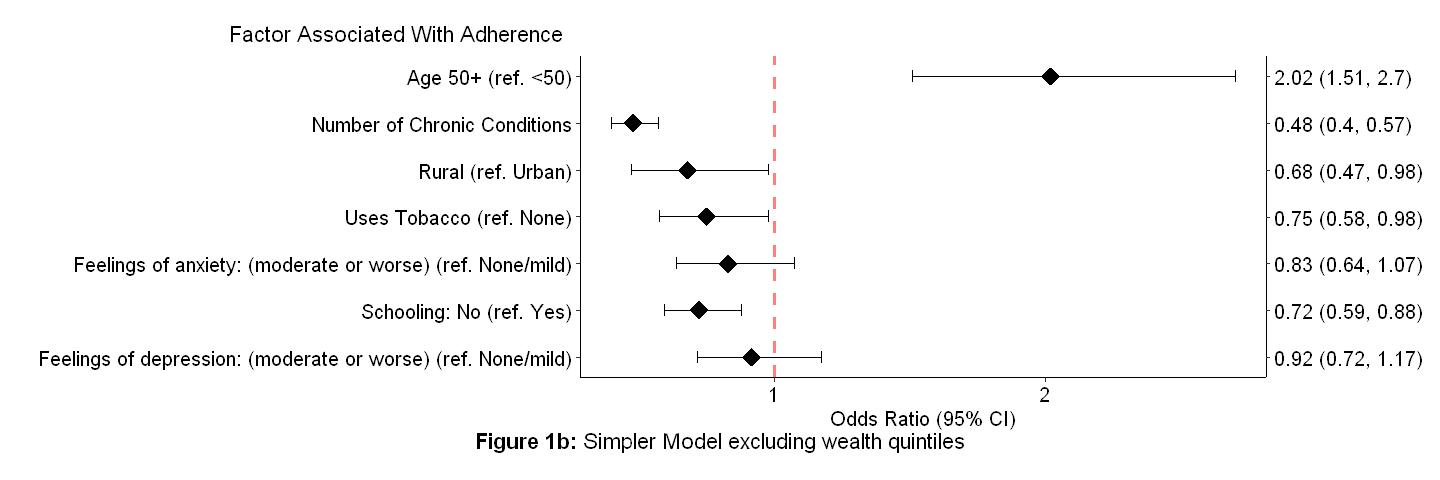

In [73]:
plot1 <- ggplot(dat, aes(y = Index, x = OR)) +
  theme(aspect.ratio = 10) +
  geom_point(shape = 18, size = 5) +  
  geom_errorbarh(aes(xmin = LL, xmax = UL), height = 0.25) +
  geom_vline(xintercept = 1, color = "red", linetype = "dashed", cex = 1, alpha = 0.5) +
  scale_y_continuous(name = "", breaks=1:length(OR), labels = dat$label, trans = "reverse", 
        sec.axis = sec_axis(~.,
                    breaks = 1:length(OR),
                    labels = paste(round(OR, 2), 
                        " (",round(LL, 2), 
                         ", ", round(UL,2), ")", sep = ""  ))) +
  xlab("Odds Ratio (95% CI)") + 
  ylab(" ") + 
  ggtitle("Factor Associated With Adherence") +
  labs(tag = expression(paste(bold("Figure 1b:")," Simpler Model excluding wealth quintiles"))) +
  theme_bw() +
  theme(plot.title = element_text(hjust = -1),
        plot.tag.position = "bottom",
        plot.tag = element_text(face = "plain", size = 13), 
        panel.border = element_blank(),
        panel.background = element_blank(),
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"),
        axis.text.y = element_text(size = 12, colour = "black"),
        axis.text.x.bottom = element_text(size = 12, colour = "black"),
        axis.title.x = element_text(size = 12, colour = "black"),
        plot.margin = margin(t = 15,  # Top margin
                             r = 10,  # Right margin
                             b = 15,  # Bottom margin
                             l = 10)) # Left margin)
plot1
ggsave(file="Figures/ForestPlotWeighted.jpg", width=12, height=4, dpi=600)

## Alternative Model

In [74]:
logit2 <- (svyglm(adherence~quintile+age_category+count_diseases+q0104+q3001+q2019+q1015+q2018, family=binomial, design=Morbidity, na.action = na.omit))
#summary(logit1)
OR <- exp(coef(logit2))
CI.OR.logit2<- as.matrix(exp(confint.default(logit2)))
stargazer(logit2, coef=list(OR), ci.custom = list(CI.OR.logit2), t.auto=F, p.auto=F, ci = T, type = "text")


                           Dependent variable:    
                       ---------------------------
                                adherence         
--------------------------------------------------
quintile2                         1.072           
                             (0.783, 1.466)       
                                                  
quintile3                       1.587***          
                             (1.133, 2.223)       
                                                  
quintile4                         1.127           
                             (0.804, 1.579)       
                                                  
quintile5                         1.284           
                             (0.846, 1.949)       
                                                  
age_category> =50               2.021***          
                             (1.508, 2.709)       
                                                  
count_diseases                

In [75]:
#colnames(CI.OR)
OR <- exp(coef(logit2)[2:length(coef(logit2))])
LL<-CI.OR.logit2[,"2.5 %"][2:length(coef(logit2))]
UL<-CI.OR.logit2[,"97.5 %"][2:length(coef(logit2))]

In [76]:
dat <- data.frame(
  Index = 1:length(OR), ## This provides an order to the data
  label = c("Quintile: 2 (ref. 1)", "Quintile: 3 (ref. 1)", "Quintile: 4 (ref. 1)", "Quintile: 5 (ref. 1)", "Age 50+ (ref. <50)", 
  "Number of Chronic Conditions", "Rural (ref. Urban)",  "Uses Tobacco (ref. None)",
   "Feelings of anxiety: (moderate or worse) (ref. None/mild)", "Schooling: No (ref. Yes)",
   "Feelings of depression:  (moderate or worse) (ref. None/mild)"),#, "Age"
  OR = OR,
  LL = LL,
  UL = UL
)

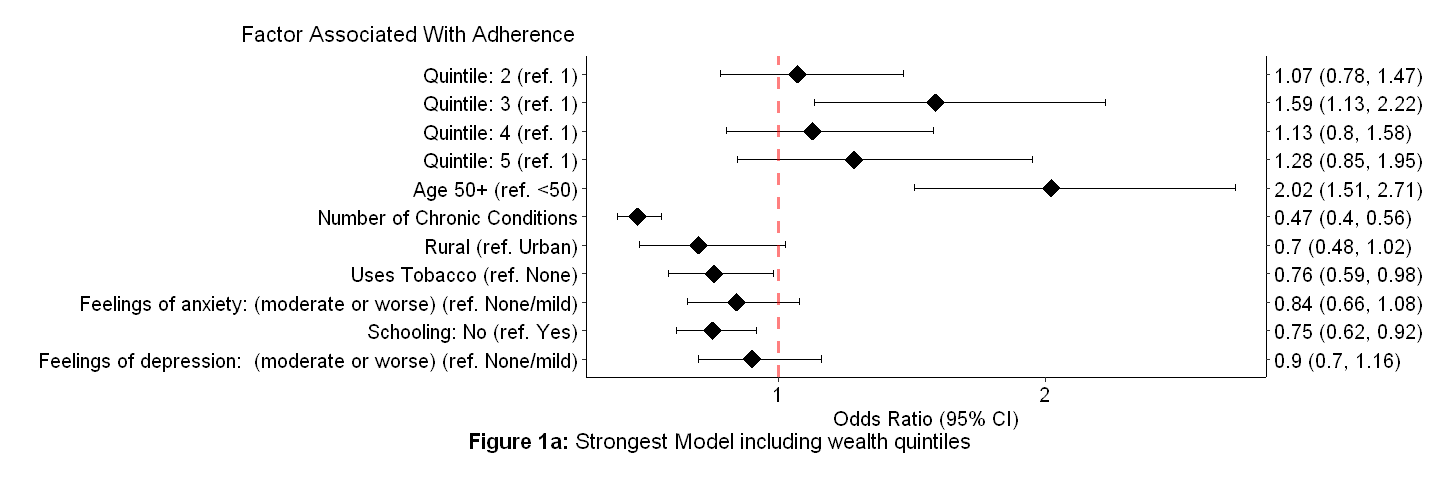

In [77]:
plot2 <- ggplot(dat, aes(y = Index, x = OR)) +
  theme(aspect.ratio = 10) +
  geom_point(shape = 18, size = 5) +  
  geom_errorbarh(aes(xmin = LL, xmax = UL), height = 0.25) +
  geom_vline(xintercept = 1, color = "red", linetype = "dashed", cex = 1, alpha = 0.5) +
  scale_y_continuous(name = " ", breaks=1:length(OR), labels = dat$label, trans = "reverse", 
        sec.axis = sec_axis(~.,
                    breaks = 1:length(OR),
                    labels = paste(round(OR, 2), 
                        " (",round(LL, 2), 
                         ", ", round(UL,2), ")", sep = ""  ))) +
  xlab("Odds Ratio (95% CI)") + 
  ylab(" ") + 
  ggtitle("Factor Associated With Adherence") +
  labs(tag = expression(paste(bold("Figure 1a:")," Strongest Model including wealth quintiles"))) +
  theme_bw() +
  theme(plot.title = element_text(hjust = -1),
        plot.tag.position = "bottom",
        plot.tag = element_text(face = "plain", size = 13), 
        panel.border = element_blank(),
        panel.background = element_blank(),
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"),
        axis.text.y = element_text(size = 12, colour = "black"),
        axis.text.x.bottom = element_text(size = 12, colour = "black"),
        axis.title.x = element_text(size = 12, colour = "black"),
        plot.margin = margin(t = 15,  # Top margin
                             r = 10,  # Right margin
                             b = 15,  # Bottom margin
                             l = 10)) # Left marg
plot2
ggsave(file="Figures/ForestPlotWeighted2.jpg", width=12, height=4, dpi=600)

In [78]:
car::vif(logit2)

,GVIF,Df,GVIF^(1/(2*Df))
quintile,2.475783,4,1.119990
age_category,1.100118,1,1.048865
count_diseases,1.144813,1,1.069959
q0104,1.606342,1,1.267416
q3001,1.221629,1,1.105273
q2019,1.679779,1,1.296063
q1015,1.201497,1,1.096128
q2018,1.749590,1,1.322721


In [79]:
options(repr.plot.width = 12, repr.plot.height = 8)

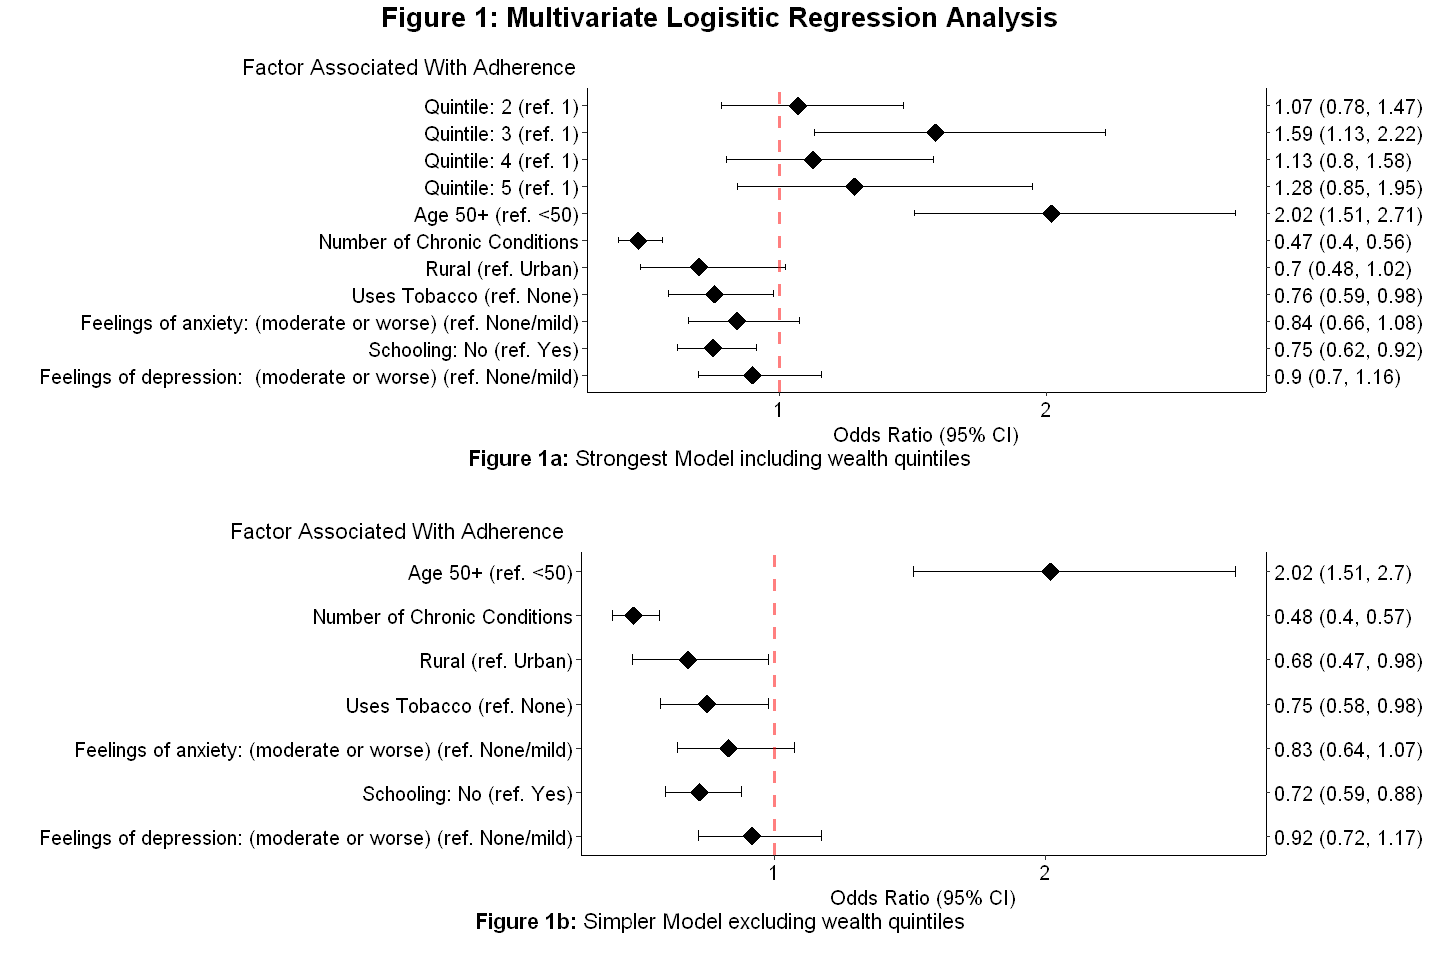

In [80]:
combined_plot <- ggarrange(plot2,
                           plot1,
                           nrow = 2,
                           ncol = 1)
combined_plot <- annotate_figure(combined_plot, top = text_grob("Figure 1: Multivariate Logisitic Regression Analysis",
               color = "black", face = "bold", size = 16))
combined_plot
ggsave(file="Figures/ForestPlotWeightedCombined.jpg", width=12, height=8, dpi=600)

# Unweighted Analysis

In [81]:
BVCalc <- function(variable, disease, adherenceQ){
    Name <- attr(disease[ ,variable[1]], "label")

    
    if (variable[2] == "D"){
        AnalysisTable <- table(disease[ ,variable[1]], disease[ ,adherenceQ])
        AnalysisTable <- AnalysisTable[,c('No', 'Yes')]
        AnalysisTable <- AnalysisTable[rowSums(AnalysisTable[])>0,] # remove empty rows
        MarginTable <- margin.table(AnalysisTable,c(1,2))
        PropTable <- 100*prop.table(AnalysisTable, margin = 2)
        p.value <- summary(AnalysisTable)$p.value
        if (p.value < 0.001){
            p.value <- paste('<0.001')
        } else {
            p.value <- paste(round(p.value, 3))
        }
        RowNames <- row.names(PropTable)
        Title <- c(paste(Name, ' [n (%)]', sep = '' ), '----', '----', p.value)
        fx <- lapply(RowNames, function(x) {
            name <- paste0('~~~', x, sep = '')
            nonAdhering <- paste(MarginTable[x, 'No'], 
            ' (',round(PropTable[x, 'No'], 2), ' %)', sep = '')
            adhering <- paste(MarginTable[x, 'Yes'], 
            ' (',round(PropTable[x, 'Yes'], 2), ' %)', sep = '')
            pval = paste('--')
            data.frame(
                Name = name,
                Nonadhering = nonAdhering,
                Adhering = adhering,
                Pvalue = pval,
                stringsAsFactors=FALSE
        )
        })
        output_dataframe <- do.call(rbind, fx)
        output_dataframe <- rbind(Title, output_dataframe)        
    }
    if (variable[2] == "C"){ #t-test is applicable here https://thestatsgeek.com/2013/09/28/the-t-test-and-robustness-to-non-normality/
        adh<-subset(disease, disease[,adherenceQ]=="Yes")
        adh <- adh[,variable[1]]
        ndh<-subset(disease, disease[,adherenceQ]=="No")
        ndh <- ndh[,variable[1]]
        adhering <- paste(signif(mean(adh, na.rm=TRUE),2), ' (',signif(sd(adh, na.rm=TRUE),2) , ')', sep = '')
        nonAdhering <- paste(signif(mean(ndh, na.rm=TRUE),2), ' (',signif(sd(ndh, na.rm=TRUE),2) , ')', sep = '')
        p.value <- t.test(adh, ndh, var.equal = FALSE)$p.value
        if (p.value < 0.001){
            p.value <- paste('<0.001')
        } else {
            p.value <- paste(round(p.value, 3))
        }
        Title <- data.frame(
                Name = paste(Name, ' [mean (SD)]', sep = '' ),
                Nonadhering = nonAdhering,
                Adhering = adhering,
                Pvalue = p.value,
                stringsAsFactors=FALSE
        )
        output_dataframe <- Title   
    }

    

    output_dataframe           

}

In [82]:
PropFunc <- function(diseaseStr, question){
    disease <- eval(parse(text = diseaseStr))
    total <- length(disease[,question])
    name <- diseaseStr
    AnalysisTable <- table(disease[,question])
    #AnalysisTable <- AnalysisTable[c('No', 'Yes')]
    PropTable <- prop.table(AnalysisTable)
    
    output_dataframe <- data.frame(
                Name = name,
                No = paste(AnalysisTable['No'], ' (', round(100*PropTable['No'],2), ' %)', sep = ''),
                Yes = paste(AnalysisTable['Yes'], ' (', round(100*PropTable['Yes'],2), ' %)', sep = ''),
                Total = total,
                stringsAsFactors=FALSE
        )
    

    output_dataframe           

}

In [83]:
VariableList <- matrix(
# disease and question
    c(     "morbidity", "adherence",
           "multimorbid", "adherence",
           "unimorbid", "adherence",
        # Chronic conditions
           "angina",  "q4015a", # Angina
         "diabetes",  "q4023a", # Diabetes
           "asthma",  "q4034a", # Asthma
"hypertension",  "q4061a", # Hypertension
           "stroke",  "q4011a", # Stroke
      "lungDisease",  "q4026a", # Lung Disease
       "depression",  "q4041a" # Clinical Depression

), ncol = 2, byrow = TRUE
)

In [84]:
dfs <- apply(VariableList, 1, function(Var) { PropFunc(Var[1],  Var[2]) } )
weightedDiseaseAdh <- do.call(rbind, dfs)
weightedDiseaseAdh
write.csv(weightedDiseaseAdh,"Misc/unweightedAdherence_by_Disease.csv")

Name,No,Yes,Total
<chr>,<chr>,<chr>,<int>
morbidity,1422 (50.07 %),1418 (49.93 %),2840
multimorbid,491 (61.15 %),312 (38.85 %),803
unimorbid,931 (45.7 %),1106 (54.3 %),2037
angina,98 (35.25 %),180 (64.75 %),278
diabetes,286 (36.57 %),496 (63.43 %),783
asthma,185 (42.33 %),252 (57.67 %),439
hypertension,754 (42.7 %),1012 (57.3 %),1768
stroke,96 (47.52 %),106 (52.48 %),202
lungDisease,104 (57.46 %),77 (42.54 %),182


In [85]:
VariableList <- matrix(
# disease and question
    c(     "morbidity", "twelve_adherence",
            "adherent", "twelve_adherence",
            "nonadherent", "twelve_adherence"
), ncol = 2, byrow = TRUE
)

In [86]:
dfs <- apply(VariableList, 1, function(Var) { PropFunc(Var[1],  Var[2]) } )
weightedDiseaseAdh <- do.call(rbind, dfs)
weightedDiseaseAdh
write.csv(weightedDiseaseAdh,"Misc/unweighted12MAdherence_by_Disease.csv")

Name,No,Yes,Total
<chr>,<chr>,<chr>,<int>
morbidity,1313 (46.23 %),1527 (53.77 %),2840
adherent,235 (3.05 %),7459 (96.95 %),7694
nonadherent,1079 (75.88 %),343 (24.12 %),1422


In [87]:
# D, C for discrete vs continuous

VariableList <- matrix(

    c(  #"q1011", "C", # age
        "age_category", "D", # age category
        "q1009",  "D", # gender
        "quintile","D", # wealth quintile     
        #"wealthscore","C", # wealth score    
        "count_diseases", "C", # Number of Morbidities        
        "q0104",  "D", # rural/urban
        "q0105a", "D", # state   
        "q1012",  "D", # current marital status         
        "q1019_", "D", # Religion        
        "q1018_", "D", # Caste        
        "q3001", "D", # tobacco        
        "q3008", "D", # alcohol
        "q2000", "D", # self reported health
        "q2010", "D", # cognitive function
        "q2002", "D", # physical function
        "q8062", "D", # community support
        "q1503", "D", # working
        "q5004", "D", # PHC
        "q1015",  "D", # schooling
        "q1016_", "D", # Highest level of schooling
        "q2018",  "D", # Depression, last 30 days
        #"q4040",  "D", # Clinical Depression
        "q2019",  "D", # Anxiety
        "q4062",  "D", # Cataracts
        "q7002", "D" # Subjective wealth
), ncol = 2, byrow = TRUE
)

In [88]:
dfs <- apply(VariableList, 1, function(Var) {BVCalc(Var, morbidity, "adherence")})
MorbidityBV <- do.call(rbind, dfs)
MorbidityBV
write.csv(MorbidityBV,"Supplementary2/MorbidityUnweightedBV.csv")

Name,Nonadhering,Adhering,Pvalue
<chr>,<chr>,<chr>,<chr>
Age Group [n (%)],----,----,<0.001
~~~<50,218 (15.33 %),119 (8.39 %),--
~~~>=50,1204 (84.67 %),1299 (91.61 %),--
Sex of the respondent [n (%)],----,----,0.165
~~~Male,637 (44.8 %),672 (47.39 %),--
~~~Female,785 (55.2 %),746 (52.61 %),--
5 quantiles of wealthscore [n (%)],----,----,<0.001
~~~1,236 (16.6 %),174 (12.27 %),--
~~~2,263 (18.5 %),205 (14.46 %),--


In [89]:
dfs <- apply(VariableList, 1, function(Var) {BVCalc(Var, multimorbid, "adherence")})
multiMorbidityBV <- do.call(rbind, dfs)
multiMorbidityBV
write.csv(MorbidityBV,"Supplementary2/multiMorbidityUnweightedBV.csv")

Name,Nonadhering,Adhering,Pvalue
<chr>,<chr>,<chr>,<chr>
[n (%)],----,----,<0.001
~~~<50,54 (11 %),9 (2.88 %),--
~~~>=50,437 (89 %),303 (97.12 %),--
[n (%)],----,----,0.116
~~~Male,227 (46.23 %),162 (51.92 %),--
~~~Female,264 (53.77 %),150 (48.08 %),--
[n (%)],----,----,0.207
~~~1,72 (14.66 %),29 (9.29 %),--
~~~2,76 (15.48 %),44 (14.1 %),--
